In [123]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [124]:
def create_X_y(df):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofmonth'] = df['date'].dt.day
    df['dayofyear'] = df['date'].dt.dayofyear
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year

    df['rolling_4_MW_mean'] = df.MW.rolling(4, 1).mean().shift().bfill()
    df['rolling_24_MW_mean'] = df.MW.rolling(24, 1).mean().shift().bfill()
    df['rolling_48_MW_mean'] = df.MW.rolling(48, 1).mean().shift().bfill()

    for i in [1, 4, 12, 24, 36, 48, 96]:
        df[f'lag_{i}'] = df.MW.shift(i).bfill()
    
    X = df[['hour', 'dayofweek', 'dayofmonth', 'dayofyear', 'month', 'quarter','year',
           'rolling_4_MW_mean', 'rolling_24_MW_mean', 'rolling_48_MW_mean',
           'lag_1', 'lag_4', 'lag_12', 'lag_24', 'lag_36', 'lag_48', 'lag_96',]]
    
    y = df['MW']

    return X, y

In [125]:
df = pd.read_csv('data.csv', index_col=['dt'])

In [126]:
df.index = pd.to_datetime(df.index)

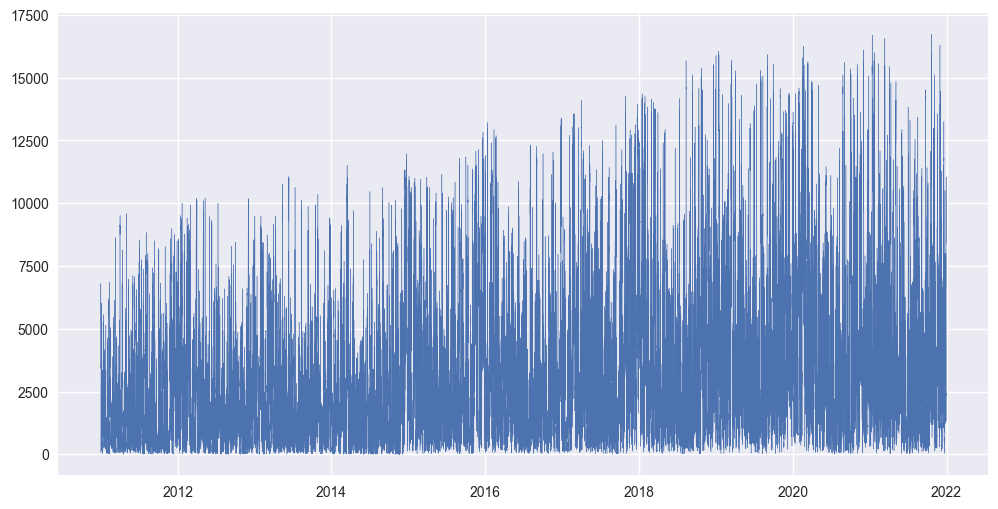

In [127]:
plt.figure(figsize=(12, 6))
plt.plot(df['MW'], linewidth=0.3)
plt.show()

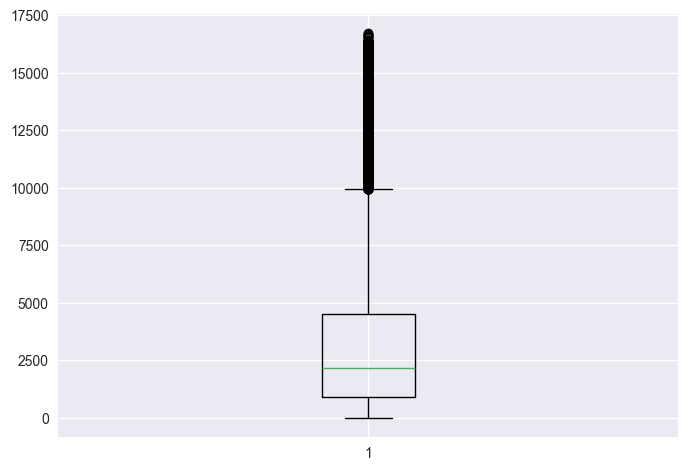

In [128]:
plt.boxplot(df['MW'])
plt.show()

##### Присутствует значительное количество выбросов.

In [129]:
df_decomposed = seasonal_decompose(df, period=35059, model='additive')

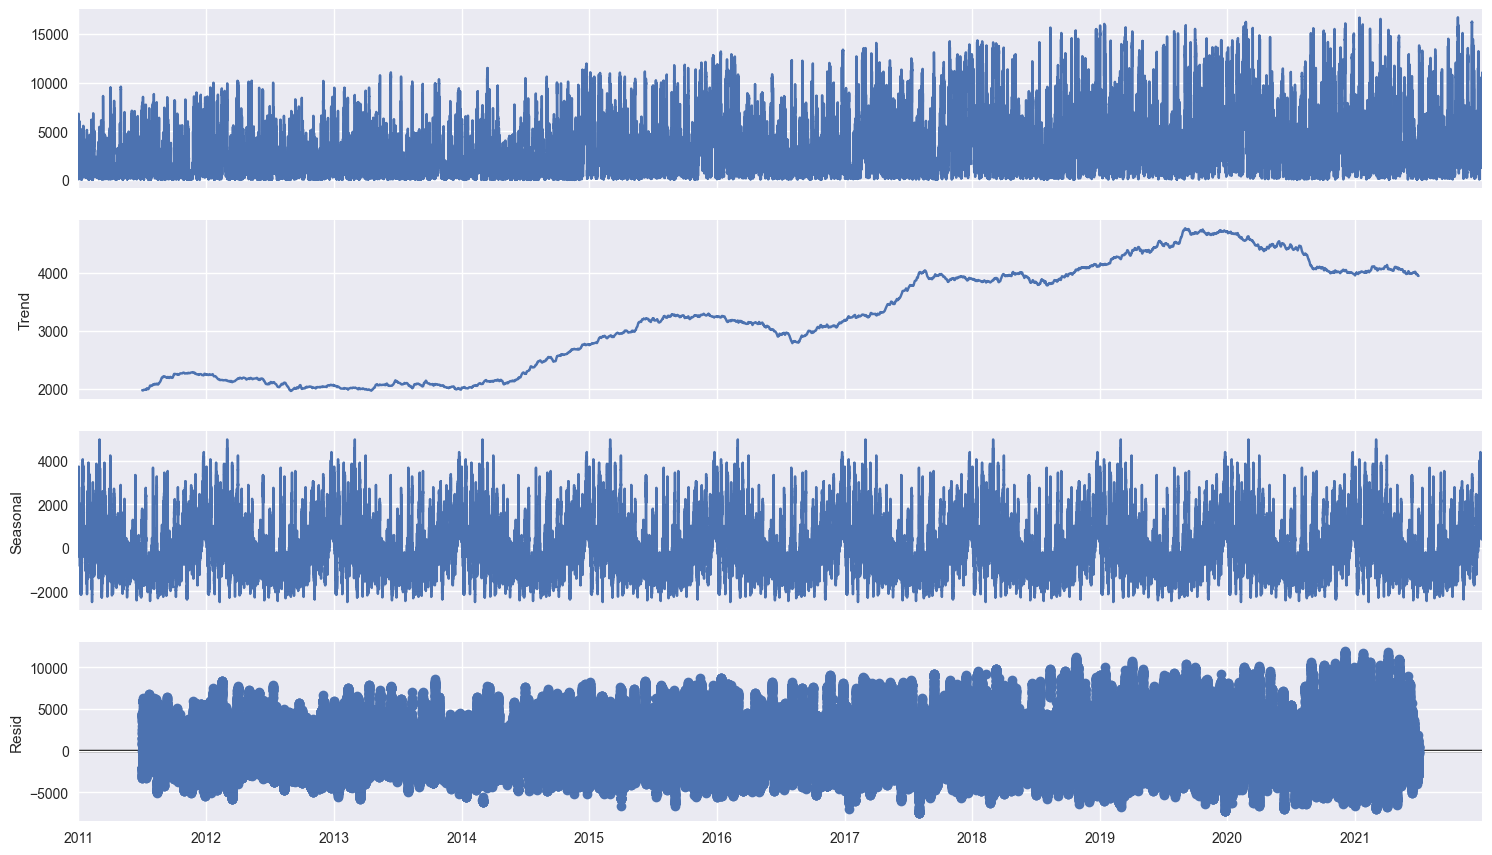

In [130]:
plot = df_decomposed.plot()
plot.set_size_inches((16, 9))
plt.show();

##### Кроме возрастающего тренда и четкой сезонности во временном ряде есть очень значительная стохастическая часть.

In [131]:
split_date = df.index[-1] - relativedelta(years=1)

train_df = df[df.index <= split_date]
test_df = df[df.index > split_date]

In [132]:
X_train, y_train = create_X_y(train_df)
X_test, y_test = create_X_y(test_df)

cat = CatBoostRegressor(loss_function='RMSE', learning_rate=0.1, max_depth=7, iterations=500) 

catreg = cat.fit(X_train, y_train, verbose_eval=100)

predictions= catreg.predict(X_test)

print('MAPE = %.2f' % mean_absolute_percentage_error(y_test, predictions) + '%')

0:	learn: 2706.3295036	total: 53.7ms	remaining: 26.8s
100:	learn: 353.4645157	total: 1.75s	remaining: 6.91s
200:	learn: 327.9928915	total: 3.35s	remaining: 4.99s
300:	learn: 313.8166129	total: 5.55s	remaining: 3.67s
400:	learn: 304.0290596	total: 8.97s	remaining: 2.21s
499:	learn: 294.8855621	total: 11.3s	remaining: 0us
MAPE = 6.88%


##### Модель CatBoostRegressor была выбрана как оптимальная по соотношению ресурсы для расчета и время, дополнительно к ней были добавлены вручную дополнительные параметры, потому что tsfresh также оказалась очень времязатратной.

In [133]:
import hvplot.pandas
import hvplot as hv

In [134]:
pred = df[df.index > split_date].copy()
pred['MW_predicted'] =  y_test


In [135]:
pred

,MW,MW_predicted
dt,,
2020-12-30 08:00:00,6464.83,6464.83
2020-12-30 08:15:00,6410.84,6410.84
2020-12-30 08:30:00,6315.27,6315.27
2020-12-30 08:45:00,6191.52,6191.52
2020-12-30 09:00:00,6138.02,6138.02
...,...,...
2021-12-30 06:45:00,8140.31,8140.31
2021-12-30 07:00:00,8162.33,8162.33
2021-12-30 07:15:00,8405.11,8405.11


In [136]:
(pred['MW'].hvplot(width=1200, height=600) * 
 pred['MW_predicted'].hvplot())

:Overlay
   .Curve.MW           :Curve   [dt]   (MW)
   .Curve.MW_predicted :Curve   [dt]   (MW_predicted)